#Artículo Medium ---- Pascal

**https://medium.com/@seihon17/aprendizajes-clave-y-mi-proyecto-final-sobre-sistemas-de-recomendaci%C3%B3n-4c63bc6f9028**

# Proyecto Pascal, SR de musicas para usuarios

In [ ]:
#Generación de datos ficticios
import pandas as pd
import random

# Nombres de usuarios
user_names = ['Alice', 'Bob', 'Carla', 'David', 'Eva', 'Frank', 'Grace', 'Hector', 'Isabel', 'Juan']

# Canciones reales
song_titles = [
    'Blinding Lights', 'Shape of You', 'Levitating', 'Stay', 'Drivers License',
    'Good 4 U', 'Senorita', 'Shallow'
]

# Crear calificaciones ficticias
ratings_data = []

random.seed(42)
for user in user_names:
    songs_sampled = random.sample(song_titles, k=4)
    for song in songs_sampled:
        rating = random.randint(2, 5)  # Escala de 2 a 5 para evitar outliers bajos
        ratings_data.append({'userID': user, 'songID': song, 'rating': rating})

df = pd.DataFrame(ratings_data)


In [ ]:
df.head()

,userID,songID,rating
0,Alice,Shape of You,3
1,Alice,Blinding Lights,3
2,Alice,Good 4 U,3
3,Alice,Levitating,2
4,Bob,Shape of You,2


Sistema de recomendación con Surprise (KNN)

In [ ]:
%pip install surprise

In [ ]:
%pip install "numpy<2.0"

In [ ]:
%pip install -U "pybind11>=2.12"

In [ ]:
import numpy as np
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# Crear objeto Reader con rango de calificación
reader = Reader(rating_scale=(1, 5))

# Cargar el dataset desde DataFrame
data = Dataset.load_from_df(df[['userID', 'songID', 'rating']], reader)

# Split en entrenamiento/prueba
trainset, testset = train_test_split(data, test_size=0.2, random_state=123)

# Elegir algoritmo KNN
algo = KNNBasic()
algo.fit(trainset)

# Predecir y evaluar
predictions = algo.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7894


0.7894098729371483

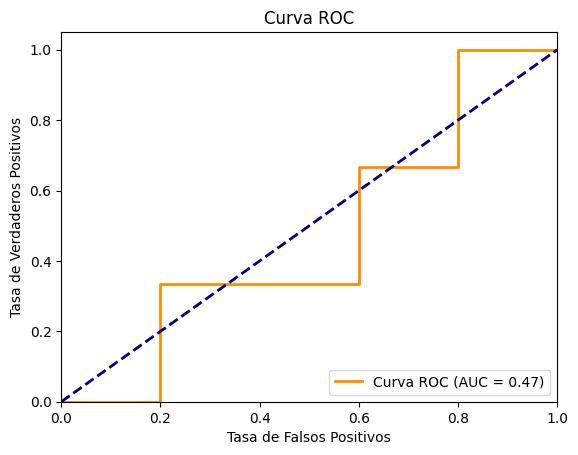

In [ ]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Generar etiquetas binarias (ej. 1 si la calificación predicha >= umbral, 0 si < umbral)
# Para propósitos de demostración, usaremos un umbral simple
# En un caso real, la curva ROC se usa típicamente para clasificadores binarios.
# Adaptaremos esto para un problema de recomendación.

# Vamos a considerar una "clasificación" binaria: si la recomendación es buena (rating > 3.5) o no.
# Primero, necesitamos los ratings reales y predichos del conjunto de prueba.
actual_ratings = np.array([pred.r_ui for pred in predictions])
predicted_ratings = np.array([pred.est for pred in predictions])

# Definir un umbral para binarizar las calificaciones reales y predichas
threshold = 3.5

# Etiquetas binarias reales (1 si la calificación real > umbral, 0 en otro caso)
# Usamos la mediana como umbral para evitar que una clase sea demasiado dominante
median_rating = np.median(actual_ratings)
true_labels = (actual_ratings > median_rating).astype(int)

# "Probabilidades" predichas para la clase positiva (rating > umbral)
# Una forma de aproximar esto en un sistema de recomendación es usar el rating predicho directamente.
# Los ratings predichos más altos corresponden a una mayor "probabilidad" de que la calificación sea mayor que el umbral.
predicted_scores = predicted_ratings

# Calcular la curva ROC y el Área bajo la curva (AUC)
# fpr: Tasa de falsos positivos
# tpr: Tasa de verdaderos positivos
# thresholds: Umbrales utilizados para binarización
fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


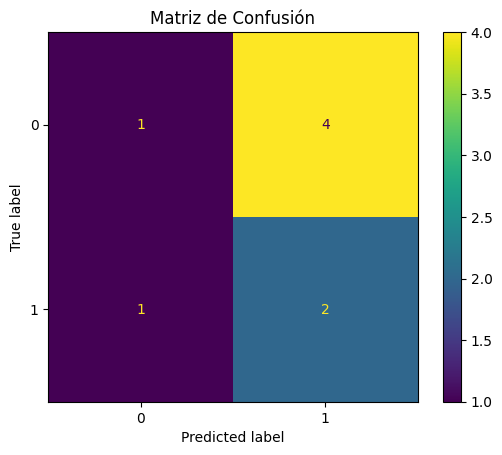

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Binarizar las predicciones basadas en el mismo umbral
predicted_labels = (predicted_ratings > median_rating).astype(int)

# Generar la matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title('Matriz de Confusión')
plt.show()


In [ ]:
def get_custom_prediction(user_id, song_title, algo):
    """
    Obtiene una predicción personalizada para un usuario y una canción específicos.

    Args:
        user_id (str): El ID del usuario.
        song_title (str): El título de la canción.
        algo: El modelo de recomendación entrenado de Surprise.

    Returns:
        float: El rating predicho para el par usuario-canción.
               Retorna un valor por defecto (ej. None o un valor bajo) si la canción no está en el dataset.
    """
    try:
        # Obtener la predicción para el par usuario-canción
        prediction = algo.predict(user_id, song_title)
        return prediction.est # El rating predicho
    except ValueError:
        # Manejar el caso donde el usuario o la canción no están en el conjunto de entrenamiento
        print(f"Usuario '{user_id}' o canción '{song_title}' no encontrada en el conjunto de entrenamiento.")
        return None

# Ejemplo de uso:
user_to_predict = 'Alice'
song_to_predict = 'Shallow' # Una canción en el dataset
# song_to_predict = 'Nueva Cancion' # Una canción que no está en el dataset

predicted_rating = get_custom_prediction(user_to_predict, song_to_predict, algo)

if predicted_rating is not None:
    print(f"El rating predicho para '{user_to_predict}' y '{song_to_predict}' es: {predicted_rating:.2f}")


El rating predicho para 'Alice' y 'Shallow' es: 3.00


Ejemplo de predicción personalizada

In [ ]:
algo.predict('Alice', 'Shallow')

Prediction(uid='Alice', iid='Shallow', r_ui=None, est=3.0, details={'actual_k': 2, 'was_impossible': False})

In [ ]:
#recomendaciones para Bob
import pandas as pd
def recommend_song_for_user(user_id, df, algo, n=1):
    """
    Recomienda las n canciones con el rating predicho más alto para un usuario dado.

    Args:
        user_id (str): El ID del usuario para el que se harán las recomendaciones.
        df (pd.DataFrame): El DataFrame original con los datos de ratings.
        algo: El modelo de recomendación entrenado de Surprise.
        n (int): El número de canciones a recomendar.

    Returns:
        list: Una lista de tuplas (song_title, predicted_rating) con las n canciones recomendadas.
              Retorna una lista vacía si el usuario no está en el dataset o no hay canciones no calificadas.
    """
    if user_id not in df['userID'].unique():
        print(f"Usuario '{user_id}' no encontrado en el dataset.")
        return []

    # Obtener todas las canciones únicas en el dataset
    all_songs = df['songID'].unique()

    # Obtener las canciones que el usuario ya ha calificado
    rated_songs = df[df['userID'] == user_id]['songID'].tolist()

    # Identificar las canciones que el usuario aún no ha calificado
    unrated_songs = [song for song in all_songs if song not in rated_songs]

    if not unrated_songs:
        print(f"El usuario '{user_id}' ya ha calificado todas las canciones disponibles.")
        return []

    # Predecir ratings para las canciones no calificadas
    predictions = []
    for song in unrated_songs:
        prediction = algo.predict(user_id, song)
        predictions.append((song, prediction.est))

    # Ordenar las predicciones por rating predicho en orden descendente
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Devolver las top n recomendaciones
    return predictions[:n]

# Ejemplo de uso:
user_to_recommend_for = 'Bob' # Puedes cambiar este usuario

recommended_songs = recommend_song_for_user(user_to_recommend_for, df, algo, n=3)

if recommended_songs:
    print(f"\nCanciones recomendadas para '{user_to_recommend_for}':")
    for song, rating in recommended_songs:
        print(f"- '{song}' con rating predicho: {rating:.2f}")



Canciones recomendadas para 'Bob':
- 'Senorita' con rating predicho: 4.39
- 'Good 4 U' con rating predicho: 3.38
- 'Shallow' con rating predicho: 3.00
